In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# move into project directory
repo_name = "UMass-CS670-Project"
%cd /content/drive/MyDrive/UMass-Courses/Semester-2/CS670/$repo_name
!ls

/content/drive/MyDrive/UMass-Courses/Semester-2/CS670/UMass-CS670-Project
common			  get_dataset.sh	   models		  sinet.py
config.yaml		  get_info.py		   output		  SINet_r18.ipynb
datautils		  github-repo-clone.ipynb  preprocess_dataset.py  source-data
demo			  Index.ipynb		   README.md		  test_seg.py
excluded-train-files.txt  index.py		   sam_vit_h_4b8939.pth   texture_params.txt
experiments		  last_run_info.json	   SINet.ipynb


In [7]:
# set up environment
# comment out if not required
'''
!pip3 install torch torchvision torchaudio
!pip install matplotlib numpy pandas pyyaml opencv-python
'''
!pip install grad-cam

!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
#!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_

In [ ]:
#!unzip -qq ./source-data/TestDataset.zip -d ./source-data/

In [ ]:
# this cell is for downloading data.
# as of yet data is not hosted and is available in the private data folder
# uncomment the lines below  to download the data

import os

!pip install gdown

data_dir="source-data"

if not(os.path.exists("source-data")):
    #!gdown https://drive.google.com/uc?id=18oBjWeuw5qAq4HG_jZdjUHas4APy-KJE&export=download
    #echo 'Downloaded data! Unzipping to data folder'
    !unzip -qq -d . ./COD10K-v3.zip
    os.rename("./COD10K-v3.zip", "./source-data/COD10K-v3.zip")
else:
    print("\nThe data directory exists!")


The data directory exists!


In [3]:
# setup some imports
from datautils.datareader import read_data
from datautils.dataset import COD10KDataset
from torch.utils.data import DataLoader
import random
import numpy as np
import torch
import argparse
from tqdm import tqdm
from torchvision.io import read_image
from torchvision.utils import save_image
from torchvision.transforms.functional import to_pil_image
import json

from experiments.style_transfer import style_transfer, run_style_transfer_pipeline
from common.visualizer import layer_visualizer
from common.utils import init_config

In [4]:
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [5]:
config_params = init_config()
print(config_params)

{'data_dir': '/content/drive/MyDrive/UMass-Courses/Semester-2/CS670/UMass-CS670-Project/source-data', 'device': 'cuda', 'output_dir': '/content/drive/MyDrive/UMass-Courses/Semester-2/CS670/UMass-CS670-Project/output', 'root_dir': '/content/drive/MyDrive/UMass-Courses/Semester-2/CS670/UMass-CS670-Project', 'use_gpu': True}


In [18]:
#sam mask generator

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from PIL import Image
import matplotlib.pyplot as plt
from common.sam_utils import show_mask, show_box

CHECKPOINT_PATH='./models/weights/sam_vit_h_4b8939.pth'

MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=config_params['device'])
mask_generator = SamAutomaticMaskGenerator(sam)


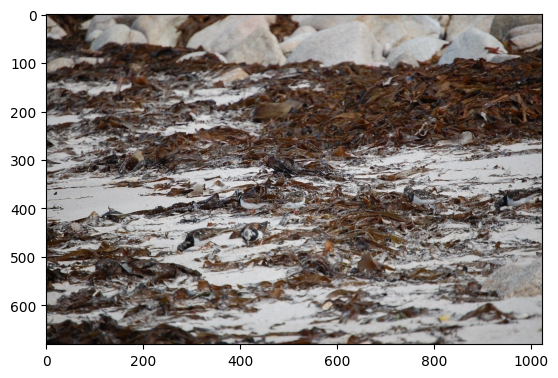

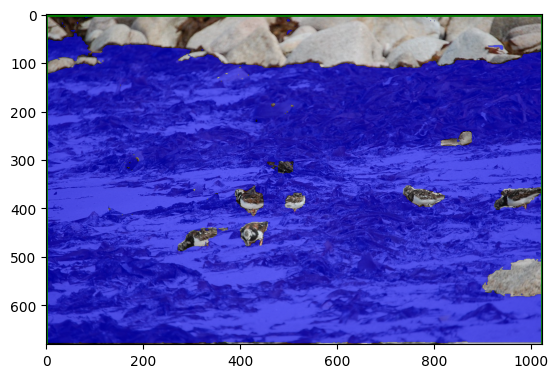

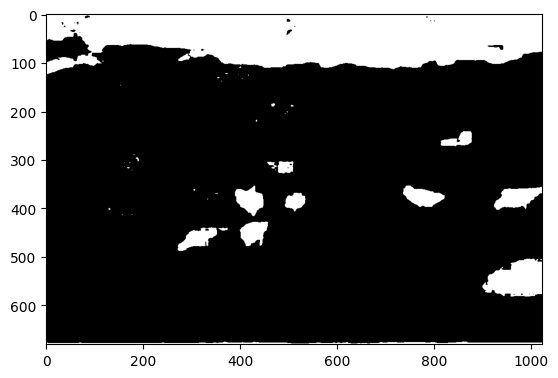

In [21]:
# sam mask for content image

image_rgb = np.array(Image.open('./source-data/Mini-Set/bgm-bird-1.jpg'))
plt.imshow(image_rgb)
plt.show()
mask_predictor = SamPredictor(sam)
mask_predictor.set_image(image_rgb)
w, h, _ = image_rgb.shape
#print(image_rgb.shape)

# Predict mask with bounding box prompt
bbox_prompt = np.array([0, 0, h, w])
masks, scores, logits = mask_predictor.predict(
box=bbox_prompt,
multimask_output=False
)


# Plot the bounding box prompt and predicted mask
plt.imshow(image_rgb)
show_mask(masks[0], plt.gca())
show_box(bbox_prompt, plt.gca())
plt.show()

plt.imshow(masks[0], cmap='binary')
plt.show()

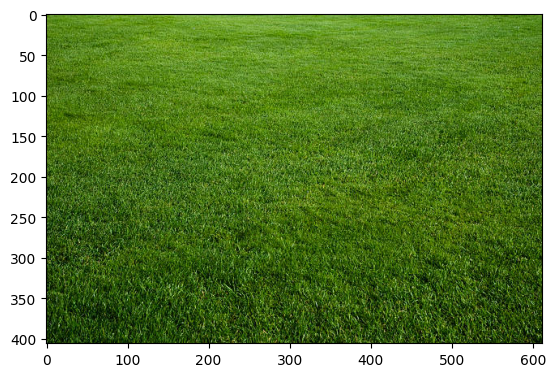

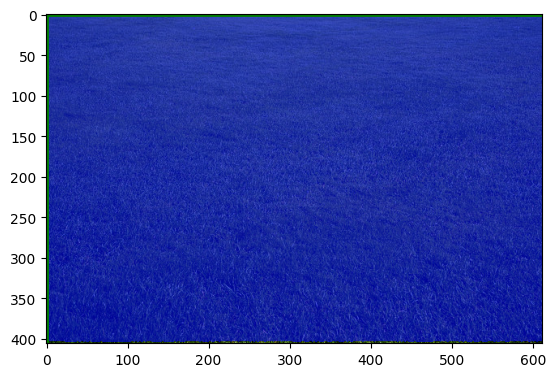

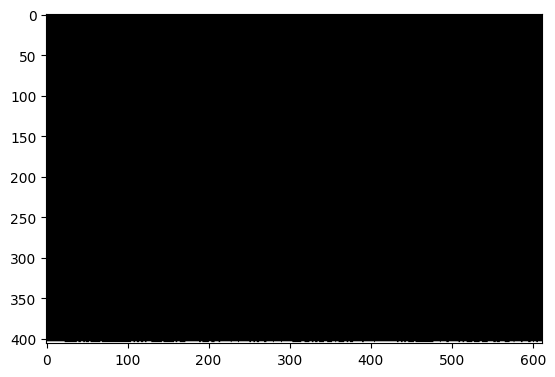

In [22]:
# sam mask for style image

image_rgb = np.array(Image.open('./source-data/Textures/grass-field.jpg'))
plt.imshow(image_rgb)
plt.show()
mask_predictor = SamPredictor(sam)
mask_predictor.set_image(image_rgb)
w, h, _ = image_rgb.shape
#print(image_rgb.shape)

# Predict mask with bounding box prompt
bbox_prompt = np.array([0, 0, h, w])
masks, scores, logits = mask_predictor.predict(
box=bbox_prompt,
multimask_output=False
)


# Plot the bounding box prompt and predicted mask
plt.imshow(image_rgb)
show_mask(masks[0], plt.gca())
show_box(bbox_prompt, plt.gca())
plt.show()

plt.imshow(masks[0], cmap='binary')
plt.show()

In [47]:

param_dict = {
    'moss': {
        'epochs': 100,
        'style_weights': 0.5
    },
    'snow': {
        'epochs': 200,
        'style_weights': 1.5
    },
    'wet-sand': {
        'epochs': 200,
        'style_weights': 3.5
    },
    'sand-with-moss': {
        'epochs': 100,
        'style_weights': 2.5
    },
    'rain': {
        'epochs': 100,
        'style_weights': 4.5
    },
    'wood': {
        'epochs': 100,
        'style_weights': 0.5
    },
    'grass': {
        'epochs': 100,
        'style_weights': 0.1
    },
    'foliage-texture': {
        'epochs': 100,
        'style_weights': 0.5
    },
    'blue-coral': {
        'epochs': 100,
        'style_weights': 1.1
    }
}

with open("./last_run_info.json") as fp:
    last_run = json.load(fp)["last_batch"]

selected_textures = ['moss', 'wet-sand', 'sand-with-moss', 'rain', 'foliage-texture']



'''
for texture in selected_textures:

    parser = argparse.ArgumentParser()
    parser.add_argument('--batch_size', type = int, default = 1)
    parser.add_argument('--model_name', type=str, default='vgg')
    parser.add_argument('--lr', type=float, default=0.05)
    parser.add_argument('--max_iter', type=int, default=param_dict[texture]['epochs'])
    args = parser.parse_args(args=[])

    style_img = read_image(f'./source-data/Textures/{texture}.jpg')
    #img = read_image('./source-data/Mini-Set/bgm-bird-1.jpg')
    #print(img.size())
    #layer_visualizer(img, args)

    run_style_transfer_pipeline(args, texture, param_dict[texture]['style_weights'], last_run)
'''

parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type = int, default = 1)
parser.add_argument('--model_name', type=str, default='vgg')
parser.add_argument('--lr', type=float, default=0.05)
parser.add_argument('--max_iter', type=int, default=200)
args = parser.parse_args(args=[])

style_img = read_image(f'./source-data/Textures/vibrant-1.jpg')
img = read_image('./source-data/Mini-Set/bgm-bird-1.jpg')
img = img[None, :]
#print(img.size())
#layer_visualizer(img, args)
#layer_visualizer(style_img, args)
style_layers = [1, 6, 11, 20, 29] #[2]
#style_layers = [0, 2, 5, 14, 23]
content_layer = 20
style_weights = [1e2] * 5 #[1.5]*5
content_weight = 5 #1e-4 #1
total_variance_weight = 1e-3 #1e-5 4
style_transfer(img, style_img, style_layers, content_layer, content_weight, style_weights, total_variance_weight, args)


Output hidden; open in https://colab.research.google.com to view.

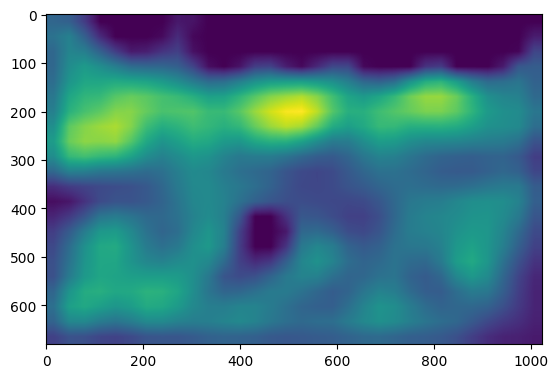

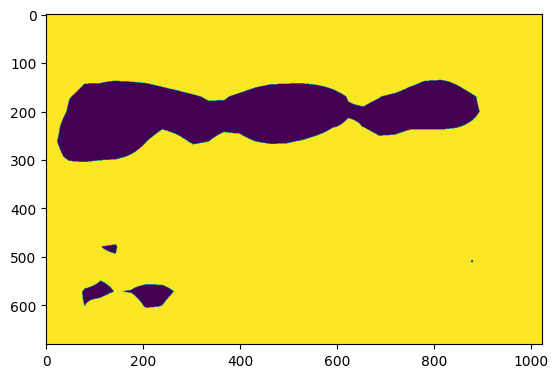

(1, 681, 1024, 3) (681, 1024)


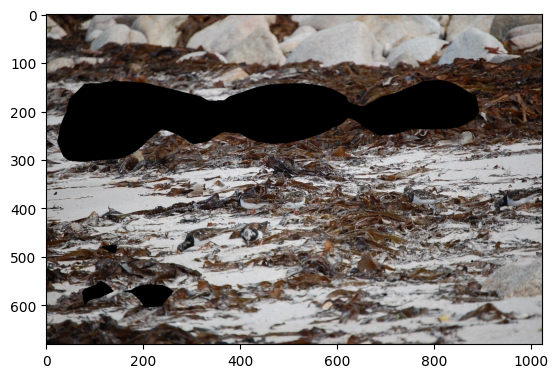

In [41]:
from models.custom_models import get_model
from common.utils import load_model, init_config
from datautils.datareader import read_data
from datautils.dataset import COD10KDataset, CamouflagedTestDataset
import random
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import torch
import argparse
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from common.utils import get_config
import os
from tqdm import tqdm
#from torchvision.io import read_image
from PIL import Image

class SemanticSegmentation:

    def __init__(self, model_path, model_name, num_classes):
        init_config()
        self.model = get_model(num_classes, model_name)
        mf = load_model(model_path)
        self.model.load_state_dict(mf)

    def __prepare_data(self, dataset_name = 'cod10k'):
        dataset = CamouflagedTestDataset(dataset_name)
        smlen = int(0.1 * len(dataset))
        #ridxs = random.sample(range(len(dataset)), smlen)
        ridxs = list(range(smlen))
        smftr_dataset = Subset(dataset, ridxs)
        return dataset, smftr_dataset

    def __image_collate(self, batch):
        batchlist = list(map(list, zip(*batch)))
        return batchlist

    def __convert_to_grascale(self, img):
        imin, imax = img.min(), img.max()
        x = (img - imin) / (imax - imin)
        return x

    def run(self, args, dataset_name = 'cod10k'):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(self.__convert_to_grascale),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
        ])
        tensor_transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        cfg = get_config()

        test_dataset, sm_test_dataset = self.__prepare_data(dataset_name)
        test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False, collate_fn = self.__image_collate)
        target_layers = [self.model.model.layer4[-1]]
        grad_cam = GradCAM(model = self.model.model, target_layers = target_layers)
        target_class = [ClassifierOutputTarget(1)]
        for i_batch, batch in enumerate(tqdm(test_loader, desc = 'Running through test set')):
            img_batch = list(map(transform, batch[0]))
            img_batch = torch.stack(img_batch, 0)
            #print('img batch', img_batch.size())
            #print(op.size())
            grayscale_cam = grad_cam(input_tensor = img_batch, targets = target_class)
            grayscale_cam = grayscale_cam[0, :, :]
            rgb_imgs = list(map(tensor_transform, batch[0]))
            rgb_imgs = np.transpose(np.stack(rgb_imgs, 0), (0, 2, 3, 1))
            rgb_imgs /= 255.0
            #print(grayscale_cam.shape, rgb_imgs.shape)
            cam_img = show_cam_on_image(rgb_imgs[0], grayscale_cam, use_rgb = True)
            cam_mask = grayscale_cam.copy()
            cam_mask[cam_mask > 0.6] = 1
            cam_mask[cam_mask <= 0.6] = 0
            cam_mask = 1 - cam_mask
            op_path = os.path.join(cfg['output_dir'], f'Test-SemSeg/{dataset_name.upper()}/{batch[2][0]}')
            op_path = op_path.replace("jpg", "png")
            #print(cfg['output_dir'], op_path)
            #print(img_batch.size(), cam_mask.shape)
            plt.imsave(op_path, cam_mask, cmap='binary')
            #plt.imshow(grayscale_cam)
            #plt.show()
            #plt.imshow(cam_mask)
            #plt.show()

    def test_on_single_image(self, args, image_path):
        target_layers = [self.model.model.layer4[-1]]
        grad_cam = GradCAM(model = self.model.model, target_layers = target_layers)
        target_class = [ClassifierOutputTarget(1)]

        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(self.__convert_to_grascale),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
        ])
        tensor_transform = transforms.Compose([
            transforms.ToTensor(),
        ])

        #img_tensor = read_image(image_path)
        img_arr = [Image.open(image_path)]
        img_tensor = list(map(transform, img_arr))
        img_tensor = torch.stack(img_tensor, 0)
        #print('img size', img_tensor.size())
        grayscale_cam = grad_cam(input_tensor = img_tensor, targets = target_class)
        grayscale_cam = grayscale_cam[0, :, :]
        rgb_imgs = list(map(tensor_transform, img_arr))
        rgb_imgs = np.transpose(np.stack(rgb_imgs, 0), (0, 2, 3, 1))
        rgb_imgs /= 255.0
        #print(grayscale_cam.shape, rgb_imgs.shape)
        cam_img = show_cam_on_image(rgb_imgs[0], grayscale_cam, use_rgb = True)
        cam_mask = grayscale_cam.copy()
        cam_mask[cam_mask > 0.6] = 1
        cam_mask[cam_mask <= 0.6] = 0
        cam_mask = 1 - cam_mask
        #op_path = os.path.join(cfg['output_dir'], f'Test-SemSeg/{dataset_name.upper()}/{batch[2][0]}')
        #op_path = op_path.replace("jpg", "png")
        #print(cfg['output_dir'], op_path)
        #print(img_batch.size(), cam_mask.shape)
        #plt.imsave(op_path, cam_mask, cmap='binary')
        plt.imshow(grayscale_cam)
        plt.show()
        plt.imshow(cam_mask)
        plt.show()
        img_np = np.array(img_arr)
        img_np[0] = img_np[0] * cam_mask[:, :, None]
        print(img_np.shape, cam_mask.shape)
        plt.imshow(img_np[0])
        plt.show()


def run_semantic_segmentation_pipeline(args, dataset_name):
    seg = SemanticSegmentation(args.model_path, 'resnet18', 2)

    #seg.run(args, dataset_name)
    seg.test_on_single_image(args, './source-data/Mini-Set/bgm-bird-1.jpg')

parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type = int, default = 1)
parser.add_argument('--model_name', type=str, default='vgg')
parser.add_argument('--lr', type=float, default=0.05)
parser.add_argument('--max_iter', type=int, default=param_dict['grass']['epochs'])
parser.add_argument('--model_path', type=str, default='./models/best_models/resnet-18-best-1.pt')
args = parser.parse_args(args=[])

run_semantic_segmentation_pipeline(args, 'cod10k')


Running epoch 0


	Running through validation set: 100%|██████████| 19/19 [00:45<00:00,  2.39s/it]


Running epoch 1


	Running through validation set: 100%|██████████| 19/19 [00:45<00:00,  2.41s/it]


Running epoch 2


	Running through validation set: 100%|██████████| 19/19 [00:45<00:00,  2.41s/it]


Running epoch 3


	Running through validation set: 100%|██████████| 19/19 [00:47<00:00,  2.51s/it]


Running epoch 4


	Running through validation set: 100%|██████████| 19/19 [00:47<00:00,  2.49s/it]


Running epoch 5


	Running through validation set: 100%|██████████| 19/19 [00:47<00:00,  2.50s/it]


Running epoch 6


	Running through validation set: 100%|██████████| 19/19 [00:47<00:00,  2.51s/it]


Running epoch 7


	Running through validation set: 100%|██████████| 19/19 [00:45<00:00,  2.40s/it]


Running epoch 8


	Running through validation set: 100%|██████████| 19/19 [00:46<00:00,  2.47s/it]


Running epoch 9


	Running through validation set: 100%|██████████| 19/19 [00:45<00:00,  2.40s/it]


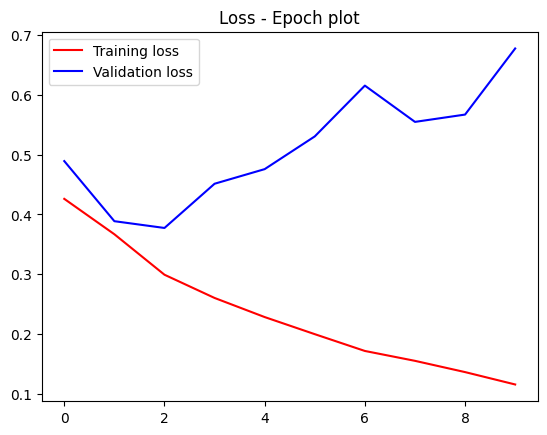

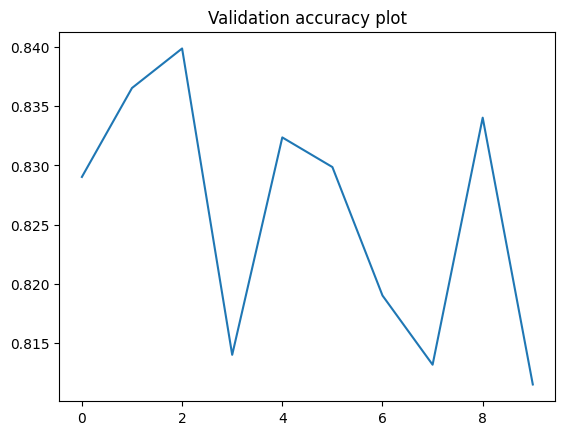

Running through test set: 100%|██████████| 63/63 [02:32<00:00,  2.42s/it]



Test accuracy:  tensor(0.8270)


In [ ]:
'''

from experiments.classification import Classification

parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type = int, default = 64)
parser.add_argument('--model_name', type=str, default='resnet18')
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--max_iter', type=int, default=10)
parser.add_argument('--resize_size', type=int, default=224)
args = parser.parse_args(args=[])

classification = Classification()

classification.run_binary_classification_pipeline(args)


'''



In [ ]:
'''

#from experiments.segmentation import run_semantic_segmentation_pipeline
from experiments.evaluate import eval_segmentation
from common.utils import get_config

parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type = int, default = 1)
parser.add_argument('--model_name', type=str, default='resnet18')
parser.add_argument('--lr', type=float, default=0.001)
parser.add_argument('--max_iter', type=int, default=5)
parser.add_argument('--resize_size', type=int, default=336)
parser.add_argument('--model_path', type=str, default='./models/checkpoints/resnet-18-best-1.pt')

args = parser.parse_args([])

cfg = get_config()

cod10k_res_path = f'{cfg["output_dir"]}/Test-SemSeg/COD10K'
cod10k_gt_path = f'{cfg["data_dir"]}/TestDataset/COD10K/GT'

camo_res_path = f'{cfg["output_dir"]}/Test-SemSeg/CAMO'
camo_gt_path = f'{cfg["data_dir"]}/TestDataset/CAMO/GT'


chameleon_res_path = f'{cfg["output_dir"]}/Test-SemSeg/CHAMELEON'
chameleon_gt_path = f'{cfg["data_dir"]}/TestDataset/CHAMELEON/GT'

#run_semantic_segmentation_pipeline(args, 'chameleon')
#print('\nEvaluage predicted segmentation masks on chameleon dataset\n')
#eval_segmentation(chameleon_res_path, chameleon_gt_path)

run_semantic_segmentation_pipeline(args, 'camo')
print('\nEvaluage predicted segmentation masks on camo dataset\n')
eval_segmentation(camo_res_path, camo_gt_path)

#run_semantic_segmentation_pipeline(args, 'cod10k')
#print('\nEvaluage predicted segmentation masks on cod10k dataset\n')
#eval_segmentation(cod10k_res_path, cod10k_gt_path)


'''

